# 0. Imports & Functions

In [3]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from skfda.representation.basis import BSplineBasis
from skfda.misc.regularization import L2Regularization
from skfda.misc.operators import LinearDifferentialOperator
from skfda.preprocessing.smoothing import BasisSmoother
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold
from collections import defaultdict
import skfda

from sklearn.metrics import mean_squared_error, r2_score

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold, GroupKFold
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.distributed
import pandas as pd
import numpy as np
from ABRA_35 import interpolate_and_smooth, CNN, plot_wave, calculate_and_plot_wave, plot_waves_single_frequency, arfread, get_str, calculate_hearing_threshold, all_thresholds, peak_finding
import warnings
from sklearn.preprocessing import StandardScaler,MinMaxScaler
warnings.filterwarnings('ignore')
import os
import io
import re
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GroupShuffleSplit
import os
import struct
import datetime
# from skfda import FDataGrid
# from skfda.preprocessing.dim_reduction import FPCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import numpy as np
import pandas as pd
import struct
import matplotlib.pyplot as plt
import torch
from scipy.ndimage import gaussian_filter1d
import torch.nn as nn
import splitfolders
# from tensorflow.keras.models import load_model
from scipy.interpolate import CubicSpline
from scipy.signal import find_peaks
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
import torch
from PIL import Image
from torchvision.transforms import ToTensor
import random
# import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
# import pytorch libraries
%matplotlib inline
import torch 
import torch.autograd as autograd 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import numpy as np4
from sklearn.metrics import r2_score
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold, cross_val_score

2025-06-24 00:13:41.360 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-24 00:13:41.445 
  command:

    streamlit run /opt/anaconda3/envs/fda-env/lib/python3.11/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-06-24 00:13:41.445 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-24 00:13:41.446 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-24 00:13:41.446 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-24 00:13:41.446 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-24 00:13:41.447 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-24 00:13:41.447 Thread 'M

In [4]:
def latency_all_peaks(highest_peaks, y_values, time_scale):
    latencies = []
    num_peaks = highest_peaks.size
    if num_peaks > 0:  # Check if highest_peaks is not empty
        for n in range(num_peaks): # SHOULD be 5 but there are cases where there are less. Will handle in later loops
            lat = highest_peaks[n] * (time_scale / len(y_values)) # Based on ABRA logic
            latencies.append(lat)
        return latencies
    else:
        print("No peaks detected. Check input data")
        return None

In [5]:
def full_interpolation(df, freq, db, time_scale=10, multiply_y_factor=1.0, units='Microvolts'):
    
    khz = df[(df['Freq(kHz)'] == freq) & (df['Level(dB)'] == db)]
    # print(khz)
    if not khz.empty:
        index = khz.index.values[0]
        final = df.loc[index, '0':].dropna()
        final = pd.to_numeric(final, errors='coerce').dropna()

        target = int(244 * (time_scale / 10))
        
        # Process the wave as in calculate_and_plot_wave
        y_values = interpolate_and_smooth(final, target)

        # print(f"Interpolated y_values: {y_values[:5]}")
        # print(f"Any NaNs? {np.isnan(y_values).any()}")

        if final.empty:
            print(f"Warning: Empty waveform for {freq}kHz @ {db}dB")
            return np.full((1, 244), np.nan)
        
        # Apply scaling factor
        y_values *= multiply_y_factor
        
        # Handle units conversion if needed
        if units == 'Nanovolts':
            y_values /= 1000
            
        # Generate normalized version for peak finding
        y_values_fpf = interpolate_and_smooth(y_values[:244])
        
        # Standardize and normalize for peak finding, exactly as in the original
        flattened_data = y_values_fpf.flatten().reshape(-1, 1)
        scaler = StandardScaler()
        standardized_data = scaler.fit_transform(flattened_data)
        min_max_scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = min_max_scaler.fit_transform(standardized_data).reshape(y_values_fpf.shape)
    
        return scaled_data

In [6]:
def peak_finding(wave):
    # Prepare waveform
    waveform=interpolate_and_smooth(wave) # Added indexing per calculate and plot wave function
    # waveform_torch = torch.tensor(waveform, dtype=torch.float32).unsqueeze(0) archived ABRA
    waveform_torch = torch.tensor(waveform, dtype=torch.float32).unsqueeze(0).unsqueeze(0) #newer ABRA
    # print(waveform_torch)
    # Get prediction from model
    outputs = peak_finding_model(waveform_torch)
    prediction = int(round(outputs.detach().numpy()[0][0], 0))
    # prediction_test = int(round(outputs.detach().numpy()[0], 0))
    # print("Model output:", outputs, "Prediction true start:", prediction)

    # Apply Gaussian smoothing
    smoothed_waveform = gaussian_filter1d(waveform, sigma=1)

    # Find peaks and troughs
    n = 18
    t = 14
    # start_point = prediction - 9 archived ABRA
    start_point = prediction - 6 #newer ABRA
    smoothed_peaks, _ = find_peaks(smoothed_waveform[start_point:], distance=n)
    smoothed_troughs, _ = find_peaks(-smoothed_waveform, distance=t)
    sorted_indices = np.argsort(smoothed_waveform[smoothed_peaks+start_point])
    highest_smoothed_peaks = np.sort(smoothed_peaks[sorted_indices[-5:]] + start_point)
    relevant_troughs = np.array([])
    for p in range(len(highest_smoothed_peaks)):
        c = 0
        for t in smoothed_troughs:
            if t > highest_smoothed_peaks[p]:
                if p != 4:
                    try:
                        if t < highest_smoothed_peaks[p+1]:
                            relevant_troughs = np.append(relevant_troughs, int(t))
                            break
                    except IndexError:
                        pass
                else:
                    relevant_troughs = np.append(relevant_troughs, int(t))
                    break
    relevant_troughs = relevant_troughs.astype('i')
    return highest_smoothed_peaks, relevant_troughs

def extract_metadata(metadata_lines):
    # Dictionary to store extracted metadata
    metadata = {}
    
    for line in metadata_lines:
        # Extract SW FREQ
        freq_match = re.search(r'SW FREQ:\s*(\d+\.?\d*)', line)
        if freq_match:
            metadata['SW_FREQ'] = float(freq_match.group(1))
        
        # Extract LEVELS
        levels_match = re.search(r':LEVELS:\s*([^:]+)', line)
        if levels_match:
            # Split levels and convert to list of floats
            metadata['LEVELS'] = [float(level) for level in levels_match.group(1).split(';') if level]
    
    return metadata

def read_custom_tsv(file_path):
    # Read the entire file
    with open(file_path, 'r', encoding='ISO-8859-1') as f:
        content = f.read()
    
    # Split the content into metadata and data sections
    metadata_lines = []
    data_section = None
    
    # Find the ':DATA' marker
    data_start = content.find(':DATA')
    
    if data_start != -1:
        # Extract metadata (lines before ':DATA')
        metadata_lines = content[:data_start].split('\n')
        
        # Extract data section
        data_section = content[data_start:].split(':DATA')[1].strip()
    
    # Extract specific metadata
    metadata = extract_metadata(metadata_lines)
    
    # Read the data section directly
    try:
        # Use StringIO to create a file-like object from the data section
        raw_data = pd.read_csv(
            io.StringIO(data_section), 
            sep='\s+',  # Use whitespace as separator
            header=None
        )
        raw_data = raw_data.T
        # Add metadata columns to the DataFrame
        if 'SW_FREQ' in metadata:
            raw_data['Freq(kHz)'] = metadata['SW_FREQ']
            # raw_data['Freq(Hz)'] = raw_data['Freq(Hz)'].apply(lambda x: x*1000)
        
        if 'LEVELS' in metadata:
            # Repeat levels to match the number of rows
            levels_repeated = metadata['LEVELS'] * (len(raw_data) // len(metadata['LEVELS']) + 1)
            raw_data['Level(dB)'] = levels_repeated[:len(raw_data)]
        
        filtered_data = raw_data.apply(pd.to_numeric, errors='coerce').dropna()
        filtered_data.columns = filtered_data.columns.map(str)

        columns = ['Freq(kHz)'] + ['Level(dB)'] + [col for col in filtered_data.columns if col.isnumeric() == True]
        filtered_data = filtered_data[columns]
        return filtered_data
    
    except Exception as e:
        print(f"Error reading data: {e}")
        return None, metadata

In [7]:
def peaks_troughs_amp_final(df, freq, db, time_scale=10, multiply_y_factor=1.0, units='Microvolts'):
    db_column = 'Level(dB)'
    
    khz = df[(df['Freq(kHz)'] == freq) & (df[db_column] == db)]
    if not khz.empty:
        index = khz.index.values[0]
        final = df.loc[index, '0':].dropna()
        final = pd.to_numeric(final, errors='coerce').dropna()

        target = int(244 * (time_scale / 10))
        
        # Process the wave as in calculate_and_plot_wave
        y_values = interpolate_and_smooth(final, target)
        
        # Apply scaling factor
        y_values *= multiply_y_factor
        
        # Handle units conversion if needed
        if units == 'Nanovolts':
            y_values /= 1000
            
        # Generate normalized version for peak finding
        y_values_fpf = interpolate_and_smooth(y_values[:244])
        
        # Standardize and normalize for peak finding, exactly as in the original
        flattened_data = y_values_fpf.flatten().reshape(-1, 1)
        scaler = StandardScaler()
        standardized_data = scaler.fit_transform(flattened_data)
        min_max_scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = min_max_scaler.fit_transform(standardized_data).reshape(y_values_fpf.shape)
        y_values_fpf = interpolate_and_smooth(scaled_data[:244])
        
        # Find peaks using the normalized data
        highest_peaks, relevant_troughs = peak_finding(y_values_fpf)
        
        # Calculate amplitude on the processed but non-normalized data
        if highest_peaks.size > 0 and relevant_troughs.size > 0:
            # Following the same approach as in the display_metrics_table function
            first_peak_amplitude = y_values[highest_peaks[0]] - y_values[relevant_troughs[0]]
            return highest_peaks, relevant_troughs, first_peak_amplitude
    
    return None, None, None

# 1. Data Processing

## Initial Data Collection

In [8]:
filter1 = 128
filter2 = 32
dropout1 = 0.5
dropout2 = 0.3
dropout_fc = 0.1

# Model initialization
peak_finding_model = CNN(filter1, filter2, dropout1, dropout2, dropout_fc)
model_loader = torch.load('./models/waveI_cnn.pth')
peak_finding_model.load_state_dict(model_loader)
peak_finding_model.eval()

CNN(
  (conv1): Conv1d(1, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(128, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=1952, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (dropout_fc): Dropout(p=0.1, inplace=False)
  (batch_norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [9]:
# del int
time_scale = 18
amp_per_freq = {'Subject': [], 'Latencies' : [], 'Freq(kHz) (x1)': [], 'Level(dB) (x2)': [], 'Amplitude (x3)':[]}
start_path = '/Users/leahashebir/Downloads/Manor_Practicum/liberman_data/abr_data/WPZ Electrophysiology'
for subject in os.listdir(start_path):
    # print("Subject:",subject)
    for fq in os.listdir(os.path.join(start_path,subject)):
        # print(fq)
        if fq.startswith('ABR') and fq.endswith('.tsv'):
            path = os.path.join(start_path,subject,fq)
            data_df = read_custom_tsv(path)
            # print(data_df)
            freqs = data_df['Freq(kHz)'].unique().tolist()
            levels = data_df['Level(dB)'].unique().tolist()
            for freq in freqs:
                for lvl in levels:
                    highest_peaks, y_values, amp = peaks_troughs_amp_final(df=data_df, freq=freq, db=lvl, time_scale=time_scale)
                    latencies = latency_all_peaks(highest_peaks, y_values, time_scale)
                    if len(latencies) < 5:
                        print(subject, freq , latencies)
                        continue
                    amp_per_freq['Subject'].append(subject)
                    amp_per_freq['Freq(kHz) (x1)'].append(freq)
                    amp_per_freq['Level(dB) (x2)'].append(lvl)
                    amp_per_freq['Amplitude (x3)'].append(amp)
                    amp_per_freq['Latencies'].append(latencies)
        else:
            pass


amp_df_full = pd.DataFrame(data=amp_per_freq)

raw_synapse_counts = pd.read_excel('/Users/leahashebir/Downloads/Manor_Practicum/liberman_data/WPZ Ribbon and Synapse Counts.xlsx')
# raw_synapse_counts = raw_synapse_counts.mask(lambda x: x.isnull()).dropna() # old approach 
raw_synapse_counts = raw_synapse_counts.mask(lambda x: x.isna(),0)
raw_synapse_counts['Synapses to IHC (y1)'] = raw_synapse_counts.iloc[:,6]
raw_synapse_counts['vx (x4)'] = raw_synapse_counts['vx']
raw_synapse_counts.drop(columns=['vx'], inplace=True)
raw_synapse_counts.rename(columns={'Freq':'Freq(kHz) (x1)'}, inplace=True)
raw_synapse_counts.rename(columns={'Case':'Subject'}, inplace=True)

WPZ62 45.2 [np.float64(486.0), np.float64(762.0), np.float64(1110.0), np.float64(1350.0)]


In [10]:
# Version 1 - values per vx

paired = amp_df_full.join(raw_synapse_counts.set_index(['Subject', 'Freq(kHz) (x1)']), on=['Subject', 'Freq(kHz) (x1)'])
# slice = paired[paired['Subject']=='WPZ174'][['Subject', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)','Synapses to IHC (y1)', 'IHCs (y2)']]
final = paired[['Subject', 'Latencies', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)','Synapses to IHC (y1)', 'IHCs']]
final_clean = final.dropna()

# adding in the strain feature
strains = pd.read_excel('/Users/leahashebir/Downloads/Manor_Practicum/liberman_data/WPZ Mouse groups.xlsx')
final_clean_strained = final_clean.join(strains.set_index('ID#'), on='Subject')
final_clean_strained['Strain'] = final_clean_strained['Strain'].str.strip()
final_clean_strained = final_clean_strained.rename(columns={'Strain': 'Strain (x5)'})
final_clean_strained = final_clean_strained.dropna()
final_clean_strained = final_clean_strained[['Subject', 'Latencies', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)', 'Strain (x5)', 'Synapses to IHC (y1)', 'Group']]

final_clean_strained_grouped = final_clean_strained.copy()
final_clean_strained_grouped['Group - dB'] = final_clean_strained_grouped['Group'].apply(lambda x: x.split(' ')[0] if x.split(' ')[0].endswith('dB') else 'Control')
final_clean_strained_grouped['Group - Time Elapsed'] = final_clean_strained_grouped['Group'].apply(lambda x: x.split(' ')[1] if x.split(' ')[1].endswith(('h', 'wks', 'w')) else x.split(' ')[0])
final_clean_strained_grouped.head()

final_clean_strained_grouped_pos = final_clean_strained_grouped.copy()
final_clean_strained_grouped_pos['Amplitude (x3)'] = final_clean_strained_grouped['Amplitude (x3)'].apply(lambda x: 0 if x < 0 else x)

final_clean_strained_grouped_pos_cleangroup = final_clean_strained_grouped_pos.copy()
final_clean_strained_grouped_pos_cleangroup['Group'] = final_clean_strained_grouped_pos_cleangroup['Group'].apply(lambda x: x.strip())

final_clean_strained_grouped_pos_cleangroup.head()
final_clean_strained_grouped_pos_cleangroup_vs = final_clean_strained_grouped_pos_cleangroup.copy()
final_clean_strained_grouped_pos_cleangroup_vs['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs['Group - dB']
# final_clean_strained_grouped_pos_cleangroup_vs['Group - Time Elapsed (x7)'] = final_clean_strained_grouped_pos_cleangroup_vs['Group - Time Elapsed']
final_clean_strained_grouped_pos_cleangroup_vs = final_clean_strained_grouped_pos_cleangroup_vs[['Subject','Latencies', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)',
       'vx (x4)', 'Strain (x5)','Group - dB (x6)', 'Group - Time Elapsed', 'Group','Synapses to IHC (y1)']]

def split_on_number(input_string):
    return re.findall(r"[A-Za-z]+|\d+", input_string)

hrs_week = 24*7

final_clean_strained_grouped_pos_cleangroup_vs_timed = final_clean_strained_grouped_pos_cleangroup_vs.copy()
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'].apply(lambda x: '0dB' if x == 'Control' else x)
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'].apply(split_on_number)
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'].apply(lambda x: x[0])
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - dB (x6)'].apply(lambda x: int(x.strip()))
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Split'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed'].apply(split_on_number)
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Magn.'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Split'].apply(lambda x: x[0])
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Magn.'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Magn.'].apply(lambda x: int(x.strip()))
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Unit'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Split'].apply(lambda x: x[1])
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Unit'] = final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Time Elapsed - Unit'].apply(lambda x: "wks" if x == 'w' else x)
final_clean_strained_grouped_pos_cleangroup_vs_timed['Group - Hours Elapsed (x7)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed.apply(lambda row: row['Group - Time Elapsed - Magn.']* hrs_week if row['Group - Time Elapsed - Unit'] == 'wks' else row['Group - Time Elapsed - Magn.'], axis = 1)

final_clean_strained_grouped_pos_cleangroup_vs_timed_avgvx_encoded = final_clean_strained_grouped_pos_cleangroup_vs_timed.copy()
final_clean_strained_grouped_pos_cleangroup_vs_timed_avgvx_encoded['Strain encoded (x5)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed_avgvx_encoded['Strain (x5)'].apply(lambda x: 0 if x=='C57B6' else 1)
final_clean_strained_grouped_pos_cleangroup_vs_timed_avgvx_encoded.head()


,Subject,Latencies,Freq(kHz) (x1),Level(dB) (x2),Amplitude (x3),vx (x4),Strain (x5),Group - dB (x6),Group - Time Elapsed,Group,Synapses to IHC (y1),Group - Time Elapsed - Split,Group - Time Elapsed - Magn.,Group - Time Elapsed - Unit,Group - Hours Elapsed (x7),Strain encoded (x5)
0,WPZ145,"[337.5, 589.5, 724.5, 895.5, 1071.0]",45.2,70.0,0.033579,v1,C57B6,98,8wks,98dB 8wks post,8.750000,"[8, wks]",8,wks,1344,0
0,WPZ145,"[337.5, 589.5, 724.5, 895.5, 1071.0]",45.2,70.0,0.033579,v2,C57B6,98,8wks,98dB 8wks post,10.888889,"[8, wks]",8,wks,1344,0
1,WPZ145,"[266.40000000000003, 352.8, 525.6, 651.6, 824.4]",45.2,75.0,0.034262,v1,C57B6,98,8wks,98dB 8wks post,8.750000,"[8, wks]",8,wks,1344,0
1,WPZ145,"[266.40000000000003, 352.8, 525.6, 651.6, 824.4]",45.2,75.0,0.034262,v2,C57B6,98,8wks,98dB 8wks post,10.888889,"[8, wks]",8,wks,1344,0
2,WPZ145,"[252.0, 400.5, 715.5, 904.5, 1075.5]",45.2,80.0,0.154224,v1,C57B6,98,8wks,98dB 8wks post,8.750000,"[8, wks]",8,wks,1344,0


In [11]:
# Version 2 - Averaged per Vx

paired2 = amp_df_full.join(raw_synapse_counts.set_index(['Subject', 'Freq(kHz) (x1)']), on=['Subject', 'Freq(kHz) (x1)'])
# lilslice = paired[paired['Subject']=='WPZ174'][['Subject', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)','Synapses to IHC (y1)', 'IHCs']]
final2 = paired2[['Subject', 'Latencies', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)','Synapses to IHC (y1)', 'Synapses', 'IHCs']]
final_clean2 = final2.dropna()

# adding in the strain feature
strains = pd.read_excel('/Users/leahashebir/Downloads/Manor_Practicum/liberman_data/WPZ Mouse groups.xlsx')
final_clean_strained2 = final_clean2.join(strains.set_index('ID#'), on='Subject')
final_clean_strained2['Strain'] = final_clean_strained2['Strain'].str.strip()
final_clean_strained2 = final_clean_strained2.rename(columns={'Strain': 'Strain (x5)'})
final_clean_strained2 = final_clean_strained2.dropna()
final_clean_strained2 = final_clean_strained2[['Subject', 'Latencies', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)', 'vx (x4)', 'Strain (x5)', 'Synapses to IHC (y1)', 'Group', 'Synapses', 'IHCs']]
# np.unique(final_clean_strained2['Group'])

# final_clean_70 = final_clean[final_clean['Level(dB) (x2)'] >= 70.0]
# final_clean_strained_70 = final_clean_strained[final_clean_strained['Level(dB) (x2)'] >= 70.0]
# # np.unique(final_clean['Level(dB) (x2)']) max level is 80 db
# len(final_clean), len(final_clean_70) # 10000 less data points!!!

final_clean_strained_grouped2 = final_clean_strained2.copy()
final_clean_strained_grouped2['Group - dB'] = final_clean_strained_grouped2['Group'].apply(lambda x: x.split(' ')[0] if x.split(' ')[0].endswith('dB') else 'Control')
final_clean_strained_grouped2['Group - Time Elapsed'] = final_clean_strained_grouped2['Group'].apply(lambda x: x.split(' ')[1] if x.split(' ')[1].endswith(('h', 'wks', 'w')) else x.split(' ')[0])
final_clean_strained_grouped2.head()

final_clean_strained_grouped_pos2 = final_clean_strained_grouped2.copy()
final_clean_strained_grouped_pos2['Amplitude (x3)'] = final_clean_strained_grouped2['Amplitude (x3)'].apply(lambda x: 0 if x < 0 else x)

len(final_clean_strained_grouped_pos2[final_clean_strained_grouped_pos2['Amplitude (x3)'] < 0])

final_clean_strained_grouped_pos2['Amplitude (x3)'] = final_clean_strained_grouped2['Amplitude (x3)'].apply(lambda x: 0 if x < 0 else x)

# final_clean_strained_grouped_pos[(final_clean_strained_grouped_pos['Subject'] == 'WPZ66') & (final_clean_strained_grouped_pos['Amplitude (x3)'] ==0.055901451434921576)
final_clean_strained_grouped_pos_cleangroup2 = final_clean_strained_grouped_pos2.copy()
final_clean_strained_grouped_pos_cleangroup2['Group'] = final_clean_strained_grouped_pos_cleangroup2['Group'].apply(lambda x: x.strip())
np.unique(final_clean_strained_grouped_pos_cleangroup2['Group'])

final_clean_strained_grouped_pos_cleangroup2.head()
final_clean_strained_grouped_pos_cleangroup_vs2 = final_clean_strained_grouped_pos_cleangroup2.copy()
final_clean_strained_grouped_pos_cleangroup_vs2['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs2['Group - dB']
# final_clean_strained_grouped_pos_cleangroup_vs['Group - Time Elapsed (x7)'] = final_clean_strained_grouped_pos_cleangroup_vs['Group - Time Elapsed']
final_clean_strained_grouped_pos_cleangroup_vs2 = final_clean_strained_grouped_pos_cleangroup_vs2[['Subject',  'Latencies', 'Freq(kHz) (x1)', 'Level(dB) (x2)', 'Amplitude (x3)',
       'vx (x4)', 'Strain (x5)','Group - dB (x6)', 'Group - Time Elapsed', 'Group','Synapses to IHC (y1)', 'Synapses', 'IHCs']]

def split_on_number(input_string):
    return re.findall(r"[A-Za-z]+|\d+", input_string)

hrs_week = 24*7

final_clean_strained_grouped_pos_cleangroup_vs_timed2 = final_clean_strained_grouped_pos_cleangroup_vs2.copy()
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - dB (x6)'].apply(lambda x: '0dB' if x == 'Control' else x)
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - dB (x6)'].apply(split_on_number)
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - dB (x6)'].apply(lambda x: x[0])
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - dB (x6)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - dB (x6)'].apply(lambda x: int(x.strip()))
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed - Split'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed'].apply(split_on_number)
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed - Magn.'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed - Split'].apply(lambda x: x[0])
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed - Magn.'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed - Magn.'].apply(lambda x: int(x.strip()))
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed - Unit'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed - Split'].apply(lambda x: x[1])
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed - Unit'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Time Elapsed - Unit'].apply(lambda x: "wks" if x == 'w' else x)
final_clean_strained_grouped_pos_cleangroup_vs_timed2['Group - Hours Elapsed (x7)'] = final_clean_strained_grouped_pos_cleangroup_vs_timed2.apply(lambda row: row['Group - Time Elapsed - Magn.']* hrs_week if row['Group - Time Elapsed - Unit'] == 'wks' else row['Group - Time Elapsed - Magn.'], axis = 1)
final_clean_strained_grouped_pos_cleangroup_vs_timed2

freqs = np.unique(final_clean_strained_grouped_pos_cleangroup_vs_timed2['Freq(kHz) (x1)'])
subs = np.unique(final_clean_strained_grouped_pos_cleangroup_vs_timed2['Subject'])
final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx = final_clean_strained_grouped_pos_cleangroup_vs_timed2.copy()
for freq in freqs:
    for sub in subs:
        mask = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx[(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Freq(kHz) (x1)'] == freq) & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Subject'] == sub)] # global for updates
        if len(mask) > 0:

            mask1 = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx[(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Freq(kHz) (x1)'] == freq) & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Subject'] == sub) & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['vx (x4)'] == 'v1')]
            mask2 = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx[(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Freq(kHz) (x1)'] == freq) & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Subject'] == sub) & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['vx (x4)'] == 'v2')]

            if not mask1.empty and not mask2.empty:
                mask1 = mask1.reset_index().iloc[0,:]
                mask2 = mask2.reset_index().iloc[0,:]

                total_syns = float(mask1['Synapses'] + mask2['Synapses'])
                total_ihcs = float(mask1['IHCs'] + mask2['IHCs'])

                if total_ihcs != 0:
                    ratio = total_syns / total_ihcs

                # if total_ihcs == 0 or total_syns == 0:
                #     print(sub, freq, total_syns, total_ihcs)
                # if total_syns == 0.0 or total_ihcs == 0.0:
                #     print(sub, freq)
                mask_index = mask.index
                final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx.loc[mask_index,'Synapse to IHC Ratio per Freq (y2)'] = ratio

## Waves from FLM

In [12]:
time_scale = 18
start_path = '/Users/leahashebir/Downloads/Manor_Practicum/liberman_data/abr_data/WPZ Electrophysiology'
subject_ABRs = {}

for subject in os.listdir(start_path):
    if subject in raw_synapse_counts['Subject'].values: # excluding subjects not in synapse count file
        for fq in os.listdir(os.path.join(start_path,subject)):
            if fq.startswith('ABR') and fq.endswith('.tsv'):
                match = re.search(r'-L-([\d.]+)\.tsv$', fq)
                if match:
                    freq = float(match.group(1))
                    if freq in raw_synapse_counts[raw_synapse_counts['Subject'] == subject]['Freq(kHz) (x1)'].values:
                        # if freq == 6.0 or freq == 7.0:
                        #     print(subject, freq)
                        # freqs.add(freq)
                        path = os.path.join(start_path,subject,fq)
                        data_df = read_custom_tsv(path)
                        if data_df['Freq(kHz)'].iloc[0] == freq:
                            subject_ABRs[(subject, freq)] = data_df
                        else:
                            print(f"Skipping subject {subject}, frequency {freq} due to mismatch.")

Skipping subject WPZ144, frequency 45.2 due to mismatch.
Skipping subject WPZ161, frequency 45.2 due to mismatch.
Skipping subject WPZ156, frequency 45.2 due to mismatch.
Skipping subject WPZ146, frequency 45.2 due to mismatch.
Skipping subject WPZ178, frequency 11.3 due to mismatch.
Skipping subject WPZ98, frequency 45.2 due to mismatch.
Skipping subject WPZ155, frequency 8.0 due to mismatch.


In [13]:
final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx.head()

,Subject,Latencies,Freq(kHz) (x1),Level(dB) (x2),Amplitude (x3),vx (x4),Strain (x5),Group - dB (x6),Group - Time Elapsed,Group,Synapses to IHC (y1),Synapses,IHCs,Group - Time Elapsed - Split,Group - Time Elapsed - Magn.,Group - Time Elapsed - Unit,Group - Hours Elapsed (x7),Synapse to IHC Ratio per Freq (y2)
0,WPZ145,"[337.5, 589.5, 724.5, 895.5, 1071.0]",45.2,70.0,0.033579,v1,C57B6,98,8wks,98dB 8wks post,8.750000,77.0,8.8,"[8, wks]",8,wks,1344,9.831461
0,WPZ145,"[337.5, 589.5, 724.5, 895.5, 1071.0]",45.2,70.0,0.033579,v2,C57B6,98,8wks,98dB 8wks post,10.888889,98.0,9,"[8, wks]",8,wks,1344,9.831461
1,WPZ145,"[266.40000000000003, 352.8, 525.6, 651.6, 824.4]",45.2,75.0,0.034262,v1,C57B6,98,8wks,98dB 8wks post,8.750000,77.0,8.8,"[8, wks]",8,wks,1344,9.831461
1,WPZ145,"[266.40000000000003, 352.8, 525.6, 651.6, 824.4]",45.2,75.0,0.034262,v2,C57B6,98,8wks,98dB 8wks post,10.888889,98.0,9,"[8, wks]",8,wks,1344,9.831461
2,WPZ145,"[252.0, 400.5, 715.5, 904.5, 1075.5]",45.2,80.0,0.154224,v1,C57B6,98,8wks,98dB 8wks post,8.750000,77.0,8.8,"[8, wks]",8,wks,1344,9.831461


In [14]:
penalty = L2Regularization(linear_operator=LinearDifferentialOperator(2))
shared_grid = np.linspace(0, time_scale, 244)
# basis = BSplineBasis(n_basis=7, domain_range=(0,18)) # old
# smoother = BasisSmoother(basis=basis, return_basis=True) # , regularization=penalty, smoothing_parameter=0.1, 
time_scale = 18
subjects = []
frequencies = []
levels = []
strains = []
amps = []
raw_waves = []
newbasis_waves = []
Xs = []
ys = []
fails = []
bases = []
all_latencies = []

for (sub, freq), df in subject_ABRs.items():
    for lvl in np.unique(df['Level(dB)']):
        latencies_series = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx[(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Subject'] == sub)\
            & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Freq(kHz) (x1)'] == freq)\
                & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Level(dB) (x2)'] == lvl)]\
            ['Latencies']
        
        if len(latencies_series) == 0:
            print(f'N/A latencies: ({sub}, {freq}, {lvl}) : {latencies_series}')
            continue

        latencies = latencies_series.values[0]
        latencies = [float(x) for x in latencies]
        all_latencies.append(latencies)
        # print(latencies)

    for lvl in np.unique(df['Level(dB)']):
        strain_series = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx[(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Subject'] == sub)\
            & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Freq(kHz) (x1)'] == freq)\
                & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Level(dB) (x2)'] == lvl)]\
            ['Strain (x5)']
        
        if len(strain_series) == 0:
            print(f'Strain error, none recorded: ({sub}, {freq}, {lvl}) : {strain_series}')
            continue

        amp_series = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx[(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Subject'] == sub)\
                & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Freq(kHz) (x1)'] == freq)]['Amplitude (x3)']
        if len(amp_series) == 0:
            print(f'Amplitude error, none recorded: ({sub}, {freq}, {lvl}) : {amp_series}')

        amp = float(amp_series.values[0])

        lvl = float(lvl)
        strain = strain_series.values[0]
        wave = full_interpolation(df, freq, lvl, time_scale)
        wave = np.asarray(wave, dtype=float)
        wave = wave.reshape(1, -1)
        
        grid = time_scale * np.arange(0, 244) / 244
        wave_input = skfda.FDataGrid(data_matrix=wave,grid_points=shared_grid)

        basis = BSplineBasis(domain_range=(latencies[0], latencies[-1]),knots = latencies, order = 3)
        bases.append(basis)
        smoother = BasisSmoother(basis=basis, return_basis=True, regularization=penalty, smoothing_parameter=1.0000e+02)

        wave_newbasis = smoother.fit_transform(wave_input)[0] # smoother will allow regularization for further tuning down the line...

        X = wave_newbasis.coefficients

        y_series = final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx[(final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Subject'] == sub)\
            & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Freq(kHz) (x1)'] == freq)\
            & (final_clean_strained_grouped_pos_cleangroup_vs_timed2_avgvx['Level(dB) (x2)'] == lvl)]\
            ['Synapse to IHC Ratio per Freq (y2)']
        
        # print(y_series)

        if len(y_series) == 0 or pd.isna(y_series.iloc[0]):
            print(f'N/A y: ({sub}, {freq}, {lvl})')
            continue

        y = float(y_series.iloc[0])

        # print((sub, freq, lvl, y))
        subjects.append(sub)
        frequencies.append(freq)
        levels.append(lvl)
        strains.append(strain)
        amps.append(amp)
        raw_waves.append(wave_input)
        newbasis_waves.append(wave_newbasis)
        Xs.append(X.flatten()) # used for model fitting, same as for OLS!
        ys.append(y)


final_waves_df_new_basis_best = pd.DataFrame(data = {'Subject' : subjects, 'Freq(kHz)' : frequencies, 'Level(dB)' : levels, 'Strain' : strains, 'Amplitude' : amps, 'Latencies' : all_latencies, 'Raw Waves' : raw_waves, 'Transformed Waves (X)' : Xs, 'Synapse to IHC Ratio per Freq (y2)' : ys})
final_waves_df_new_basis_best_clean = final_waves_df_new_basis_best.dropna().reset_index(drop=True)
final_waves_df_new_basis_best_clean.head()

,Subject,Freq(kHz),Level(dB),Strain,Amplitude,Latencies,Raw Waves,Transformed Waves (X),Synapse to IHC Ratio per Freq (y2)
0,WPZ145,45.2,70.0,C57B6,0.033579,"[337.5, 589.5, 724.5, 895.5, 1071.0]",[[[Data set: [[[0.08019387]\n [0.07692435]...,"[14.209802588706461, 22.79475268826122, 66.297...",9.831461
1,WPZ145,45.2,75.0,C57B6,0.033579,"[266.40000000000003, 352.8, 525.6, 651.6, 824.4]",[[[Data set: [[[0.48986208]\n [0.52359688]...,"[137.3503329972109, 221.51175318148637, 645.65...",9.831461
2,WPZ145,45.2,80.0,C57B6,0.033579,"[252.0, 400.5, 715.5, 904.5, 1075.5]",[[[Data set: [[[0.4259677 ]\n [0.39547801]...,"[-51.02658110433057, -82.50567816399604, -240....",9.831461
3,WPZ145,8.0,30.0,C57B6,0.154656,"[147.6, 298.8, 381.6, 583.2, 727.2]",[[[Data set: [[[0.76825543]\n [0.87247968]...,"[-17.086221830415422, -28.92681192644966, -68....",13.977273
4,WPZ145,8.0,35.0,C57B6,0.154656,"[198.0, 277.2, 417.6, 496.8, 594.0]",[[[Data set: [[[0. ]\n [0.09085721]...,"[-37.06828345795197, -62.302689010032395, -146...",13.977273


## Images (convert to embeddings)

Example for a single image

In [15]:
# This attempt provides a global image embedding

from bioio import BioImage
import bioio_lif
import bioio_tifffile

path1 = '/Users/leahashebir/Downloads/Manor_Practicum/image_libs/WPZ98L.CtBP2.GluR2.NF.Myo7.IHC.11.3.v1.lif'
path2 = '/Users/leahashebir/Downloads/Manor_Practicum/image_libs/WPZ98L.CtBP2.GluR2.NF.Myo7.IHC.11.3.v2.lif'

img1 = BioImage(path1)
img2 = BioImage(path2)

# print(f"Dimensions: {img.dims}")
# print(f"Shape: {img.shape}")
# print(f"Number of channels: {img.dims.C}")
# print(f"Size of T dimension: {img.dims.T}")
# print(f"Size of Z dimension: {img.dims.Z}")

# 3D visualization of z-stack ACROSS CHANNELS

channels = []
max_projections = []
input_tensors = []

# Loop through each channel
for img in [img1, img2]:
    for c in range(img.dims.C):
        # Get data for this channel
        channel_data = img.get_image_data("ZYX", C=c, T=0)
        channels.append(channel_data)
        
        # Create max projection along Z-axis
        max_proj = np.max(channel_data, axis=0)
        max_projections.append(max_proj)

# tensor_dim_stack_normalized = (max_projections - max_projections.mean())/ (max_projections.std()+ 1e-8)

# input_tensor = torch.from_numpy(tensor_dim_stack_normalized).float()
        input_tensor = torch.from_numpy(np.array(max_projections)).float()
        input_tensor = input_tensor.unsqueeze(0)
        input_tensors.append(input_tensor)

print(input_tensors[0].shape)
print(input_tensors[1].shape)

# print(input_tensors)
input_tensors = [t.mean(dim=1, keepdim=True) for t in input_tensors]

stitched = torch.cat(input_tensors, dim=3)
stitched = stitched.unsqueeze(0)  # → [1, 1, H, W]

print(stitched.shape)
# plt.figure(figsize=(15, 5))
# for i in range(len(max_projections)):
#     plt.subplot(1, len(max_projections), i+1)
#     plt.imshow(max_projections[i], cmap='gray')
#     plt.title(f"Channel {i+1}")
# plt.tight_layout()
# plt.show()

torch.Size([1, 1, 512, 1024])
torch.Size([1, 2, 512, 1024])
torch.Size([1, 1, 1, 512, 8192])


In [16]:
# rgb_tensor = stitched.squeeze(0)[:3]  # → [3, H, W]

# # Convert to [H, W, 3] for matplotlib
# rgb_np = rgb_tensor.permute(1, 2, 0).cpu().numpy()

# # Plot
# import matplotlib.pyplot as plt

# plt.imshow(rgb_np)
# plt.axis('off')
# plt.title("Stitched RGB Image")
# plt.show()

In [17]:
def normalize_lif_tensor(tensor):
    if not isinstance(tensor, torch.Tensor):
        raise TypeError("Input must be a PyTorch tensor.")
    return (tensor - tensor.min()) / (tensor.max() - tensor.min() + 1e-8)

# Stich together images across viewing fields and normalize
# def stitch_norm_embed_per_freqband(v1_img, v2_img, sub, freq):
#     return normalize_lif_tensor(torch.cat((v1_img, v2_img), dim=0))

# 2. Multi-Modal Graph Set-up

Heterogeneous graph to place all data together

In [37]:
from torch_geometric.data import HeteroData
import hashlib

def hash_array(arr):
    return hashlib.md5(arr.tobytes()).hexdigest()

def hash_tensor(t):
    return hashlib.md5(t.numpy().tobytes()).hexdigest()

def create_hetero_graph(df):
    """
    df = subject series
    """
    data = HeteroData() # setting up a graph per subject

    # Add node features
    
    data['freq'].x = torch.tensor(df['Freq(kHz)'].values[0], dtype=torch.float).view(-1, 1)
    data['level'].x = torch.tensor(df['Level(dB)'].values[0], dtype=torch.float).view(-1, 1)
    data['amplitude'].x = torch.tensor(df['Amplitude'].values[0], dtype=torch.float).view(-1, 1)
    data['transformed_ABR_wave'].x = torch.tensor(df['Transformed Waves (X)'].values[0], dtype=torch.float).view(-1, 1)
    data['strain'].x = torch.tensor(df['Strain'].astype('category').cat.codes.values[0], dtype=torch.float).view(-1, 1)
    
    data['Image_v1'].x = torch.tensor(df['Image Embedding v1'].values[0], dtype=torch.float).view(-1, 1)
    data['Image_v2'].x = torch.tensor(df['Image Embedding v2'].values[0], dtype=torch.float).view(-1, 1)

    # OUTPUTS FROM THE MODELS!!!!!!
    # data['segmented_synapses'].x = torch.tensor(df['Synapse Segmentation Output'].values[0], dtype=torch.float).view(-1, 1) # confirm if going into a dataframe?
    # data['segmented_ihcs'].x = torch.tensor(df['IHC Segmentation Output'].values[0], dtype=torch.float).view(-1, 1) # confirm if going into a dataframe? I think will be a np output

    
    data['avg_synapse_to_ihc_ratio'].x = torch.tensor(df['Synapse to IHC Ratio per Freq (y2)'].values[0], dtype=torch.float).view(-1, 1) # eventually this will be the image embedding... this is practice

    # Add edges
    freq_indices = df.groupby('Freq(kHz)').ngroup().values
    amp_indices = df.groupby('Amplitude').ngroup().values
    strain_indices = df.groupby('Strain').ngroup().values
    ratio_indices = df.groupby('Synapse to IHC Ratio per Freq (y2)').ngroup().values

    df['image1_hash'] = df['Image Embedding v1'].apply(hash_tensor)
    df['image2_hash'] = df['Image Embedding v2'].apply(hash_tensor)

    image1_indices = df.groupby('image1_hash').ngroup().values
    image2_indices = df.groupby('image2_hash').ngroup().values

    df['wave_hash'] = df['Transformed Waves (X)'].apply(hash_array)
    waves_indices = df.groupby('wave_hash').ngroup().values
    
    data['strain', 'to', 'amplitude'].edge_index = torch.tensor([strain_indices, amp_indices], dtype=torch.long)
    data['freq', 'to', 'avg_synapse_to_ihc_ratio'].edge_index = torch.tensor([freq_indices, ratio_indices], dtype=torch.long)
    data['amplitude', 'to', 'avg_synapse_to_ihc_ratio'].edge_index = torch.tensor([amp_indices, ratio_indices], dtype=torch.long)
    data['transformed_ABR_wave', 'to', 'avg_synapse_to_ihc_ratio'].edge_index = torch.tensor([waves_indices, ratio_indices], dtype=torch.long)
    # data['strain', 'to', 'synapse_to_ihc_ratio'].edge_index = torch.tensor([strain_indices, ratio_indices], dtype=torch.long)

    # data['freq', 'to', 'image_global'].edge_index = torch.tensor([freq_indices, image_indices], dtype=torch.long)
    # data['amplitude', 'to', 'image_global'].edge_index = torch.tensor([amp_indices, image_indices], dtype=torch.long)
    # data['waves', 'to', 'image_global'].edge_index = torch.tensor([waves_indices, image_indices], dtype=torch.long)
    # data['strain', 'to', 'image_global'].edge_index = torch.tensor([strain_indices, image_indices], dtype=torch.long) # REMOVING STRAIN SINCE THIS MADE THE WAVE I COEFFICIENT NEGATIVE
    
    # data['freq', 'to', 'image_global'].edge_index = torch.tensor([freq_indices, image_indices], dtype=torch.long)
    # data['amplitude', 'to', 'image_global'].edge_index = torch.tensor([amp_indices, image_indices], dtype=torch.long)
    # data['waves', 'to', 'image_global'].edge_index = torch.tensor([waves_indices, image_indices], dtype=torch.long)
    # data['strain', 'to', 'image_global'].edge_index = torch.tensor([strain_indices, image_indices], dtype=torch.long)

    data['freq', 'to', 'Image_v1'].edge_index = torch.tensor([freq_indices, image1_indices], dtype=torch.long)
    data['amplitude', 'to', 'Image_v1'].edge_index = torch.tensor([amp_indices, image1_indices], dtype=torch.long)
    data['transformed_ABR_wave', 'to', 'Image_v1'].edge_index = torch.tensor([waves_indices, image1_indices], dtype=torch.long)
    data['strain', 'to', 'Image_v1'].edge_index = torch.tensor([strain_indices, image1_indices], dtype=torch.long)

    data['freq', 'to', 'Image_v2'].edge_index = torch.tensor([freq_indices, image2_indices], dtype=torch.long)
    data['amplitude', 'to', 'Image_v2'].edge_index = torch.tensor([amp_indices, image2_indices], dtype=torch.long)
    data['transformed_ABR_wave', 'to', 'Image_v2'].edge_index = torch.tensor([waves_indices, image2_indices], dtype=torch.long)
    data['strain', 'to', 'Image_v2'].edge_index = torch.tensor([strain_indices, image2_indices], dtype=torch.long)

    return data

In [43]:
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx

def visualize_hetero_graph(data, node_size=300):
    # Convert each edge type to a NetworkX graph separately and merge
    G = nx.MultiDiGraph()

    # Add nodes for each node type
    for node_type in data.node_types:
        num_nodes = data[node_type].num_nodes
        for i in range(num_nodes):
            G.add_node((node_type, i), label=node_type)

    # Add edges for each edge type
    for edge_type in data.edge_types:
        src_type, relation, dst_type = edge_type
        edges = data[edge_type].edge_index.T.tolist()  # shape: [num_edges, 2]
        for src, dst in edges:
            G.add_edge((src_type, src), (dst_type, dst), label=relation)

    # Position nodes by type
    pos = {}
    y_offset = 0
    for i, node_type in enumerate(data.node_types):
        nodes = [(node_type, j) for j in range(data[node_type].num_nodes)]
        x_positions = range(len(nodes))
        for x, node in zip(x_positions, nodes):
            pos[node] = (x, -i)  # space by node type row-wise

    # Draw the graph
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_size=node_size,
            node_color="skyblue", font_size=8, font_weight='bold')
    
    # Draw edge labels
    edge_labels = {(u, v): d['label'] for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

    plt.title("Heterogeneous Graph Visualization - ABR Waveform and Synapse Data")
    plt.axis("off")
    plt.show()


In [40]:
def subset_hetero_graph(data, max_nodes_per_type=5):
    sub_data = HeteroData()
    node_map = {}

    for ntype in data.node_types:
        n = min(max_nodes_per_type, data[ntype].num_nodes)
        sub_data[ntype].x = data[ntype].x[:n]
        node_map[ntype] = n

    for etype in data.edge_types:
        src, rel, dst = etype
        edge_index = data[etype].edge_index
        mask = (edge_index[0] < node_map[src]) & (edge_index[1] < node_map[dst])
        sub_data[etype].edge_index = edge_index[:, mask]

    return sub_data

# 3. Ok let's do this thing...

In [19]:
rows = []

subs = np.unique(final_waves_df_new_basis_best_clean['Subject'])

for sub in subs:
    if sub == 'WPZ116':
        # print(f"Starting on subject {sub}")
        sub_df = final_waves_df_new_basis_best_clean[final_waves_df_new_basis_best_clean['Subject'] == sub]
        freqs = np.unique(sub_df['Freq(kHz)'])
        for freq in freqs:
            print(f"  Processing frequency {freq} kHz for {sub}")
            freq_df = sub_df[sub_df['Freq(kHz)'] == freq]
            if len(freq_df) == 0:
                print(f'No data for subject {sub} at frequency {freq}')
                continue
            
            v1_img = None
            v2_img = None

            # Locate and load the corresponding images
            # Construct the expected file paths for v1 and v2 images
            v1_path = os.path.join('/Users/leahashebir/Downloads/Manor_Practicum/liberman_data/image_data', f'{sub}L.CtBP2.GluR2.NF.Myo7.IHC.{freq}.v1.lif')
            v2_path = os.path.join('/Users/leahashebir/Downloads/Manor_Practicum/liberman_data/image_data', f'{sub}L.CtBP2.GluR2.NF.Myo7.IHC.{freq}.v2.lif')

            # Print the constructed paths for verification
            print(f"    Checking v1_path: {v1_path}")
            print(f"    Checking v2_path: {v2_path}")
            print(f"    Looking for images at {v1_path} and {v2_path}")
            if os.path.exists(v1_path) and os.path.exists(v2_path):
                print(f"    Found both images for subject {sub}, freq {freq}")
                # try:
                v1_bioimg = BioImage(v1_path)
                v2_bioimg = BioImage(v2_path)
                print(f"Loaded both images for subject {sub}, freq {freq}")

                # Assuming single time point (T=0) and averaging across channels for simplicity
                v1_channel_data = [v1_bioimg.get_image_data("ZYX", C=c, T=0) for c in range(v1_bioimg.dims.C)]
                v2_channel_data = [v2_bioimg.get_image_data("ZYX", C=c, T=0) for c in range(v2_bioimg.dims.C)]

                v1_combined = np.mean(v1_channel_data, axis=0)
                v2_combined = np.mean(v2_channel_data, axis=0)

                v1_tensor = torch.from_numpy(v1_combined).float().unsqueeze(0)  # → [1, H, W]
                v2_tensor = torch.from_numpy(v2_combined).float().unsqueeze(0)  # → [1, H, W]
                
                v1_tensor = normalize_lif_tensor(v1_tensor)
                v2_tensor = normalize_lif_tensor(v2_tensor)
                
                row = freq_df.iloc[0]  # Assuming one row per subject-frequency pair

                # Add to list of rows
                rows.append({
                    'Subject': sub,
                    'Freq(kHz)': freq,
                    'Level(dB)': row['Level(dB)'],
                    'Amplitude': row['Amplitude'],
                    'Strain': row['Strain'],
                    'Latencies': row['Latencies'],
                    # 'Raw Waves': row['Raw Waves'],
                    'Transformed Waves (X)': row['Transformed Waves (X)'],
                    'Synapse to IHC Ratio per Freq (y2)': row['Synapse to IHC Ratio per Freq (y2)'],
                    'Image Embedding v1': v1_tensor,
                    'Image Embedding v2': v2_tensor
                })

                print(f"Processed subject {sub}, freq {freq}")
                # except Exception as e:
                #     print(f"Error loading images for subject {sub}, freq {freq}: {e}")
    else:
        # print(f"Skipping subject {sub}, not WPZ116")
        continue

mixed_data_df = pd.DataFrame(rows)

  Processing frequency 8.0 kHz for WPZ116
    Checking v1_path: /Users/leahashebir/Downloads/Manor_Practicum/liberman_data/image_data/WPZ116L.CtBP2.GluR2.NF.Myo7.IHC.8.0.v1.lif
    Checking v2_path: /Users/leahashebir/Downloads/Manor_Practicum/liberman_data/image_data/WPZ116L.CtBP2.GluR2.NF.Myo7.IHC.8.0.v2.lif
    Looking for images at /Users/leahashebir/Downloads/Manor_Practicum/liberman_data/image_data/WPZ116L.CtBP2.GluR2.NF.Myo7.IHC.8.0.v1.lif and /Users/leahashebir/Downloads/Manor_Practicum/liberman_data/image_data/WPZ116L.CtBP2.GluR2.NF.Myo7.IHC.8.0.v2.lif
    Found both images for subject WPZ116, freq 8.0
Loaded both images for subject WPZ116, freq 8.0
Processed subject WPZ116, freq 8.0
  Processing frequency 11.3 kHz for WPZ116
    Checking v1_path: /Users/leahashebir/Downloads/Manor_Practicum/liberman_data/image_data/WPZ116L.CtBP2.GluR2.NF.Myo7.IHC.11.3.v1.lif
    Checking v2_path: /Users/leahashebir/Downloads/Manor_Practicum/liberman_data/image_data/WPZ116L.CtBP2.GluR2.NF.Myo7

In [48]:
np.unique(final_clean_strained_grouped_pos_cleangroup_vs_timed_avgvx_encoded['Freq(kHz) (x1)'])

array([ 8. , 11.3, 16. , 22.6, 32. , 45.2])

In [41]:
graphs = {}

graph = create_hetero_graph(mixed_data_df)
graphs[sub] = graph

## Trying to visualize with a smaller graph

['freq', 'level', 'amplitude', 'transformed_ABR_wave', 'strain', 'Image_v1', 'Image_v2', 'avg_synapse_to_ihc_ratio']
[('strain', 'to', 'amplitude'), ('freq', 'to', 'avg_synapse_to_ihc_ratio'), ('amplitude', 'to', 'avg_synapse_to_ihc_ratio'), ('transformed_ABR_wave', 'to', 'avg_synapse_to_ihc_ratio'), ('freq', 'to', 'Image_v1'), ('amplitude', 'to', 'Image_v1'), ('transformed_ABR_wave', 'to', 'Image_v1'), ('strain', 'to', 'Image_v1'), ('freq', 'to', 'Image_v2'), ('amplitude', 'to', 'Image_v2'), ('transformed_ABR_wave', 'to', 'Image_v2'), ('strain', 'to', 'Image_v2')]


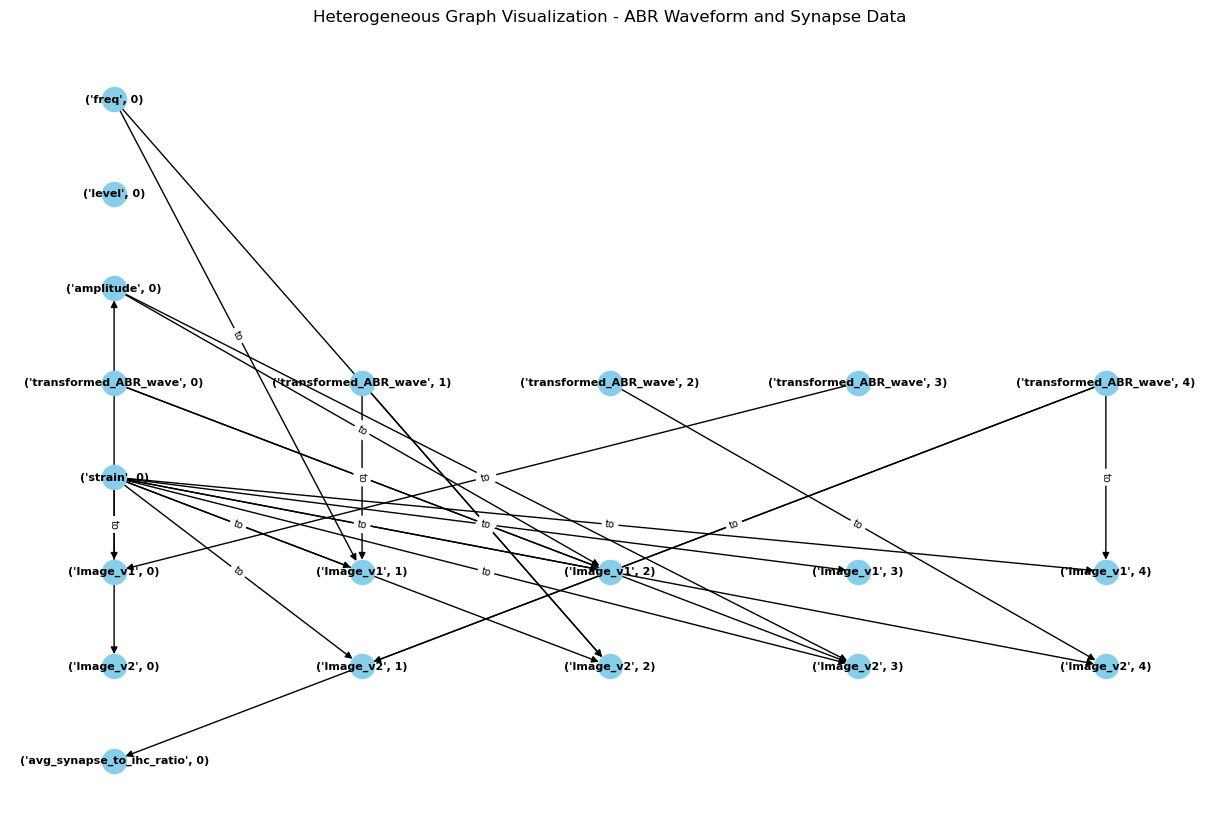

In [46]:
print(graph.node_types)
print(graph.edge_types)

small_graph = subset_hetero_graph(graph)
visualize_hetero_graph(small_graph)
